In [2]:
import numpy as np
import pandas as pd

## Standardizing data

In [60]:
def normalizacionColumna(df, i):
    columns = df.columns.values
    df[columns[i]] = (df[columns[i]] - data[columns[i]].min()) / (df[columns[i]].max() - data[columns[i]].min())
    
def normalizarDataset(data, indices):
    df = data.copy()
    for i in indices:
        normalizacionColumna(df, i)
    return df

def mapearColumna(df, col):
    val = []
    for j in range(df.shape[0]):
        val.append(df[col][j])
    unicos = list(set(val))
    for j in range(df.shape[0]):
        indice = 0
        for _ in range(len(unicos)):
            if(unicos[_] == df[col][j]):
                indice = _  + 1
                break
        val[j] = indice
    return val

def mapearColumnas(data, indices):
    df = data.copy()
    columns = df.columns.values
    for i in indices:
        df[columns[i]] = mapearColumna(df, columns[i])
    return df

def normalizarfechas(data, indices, ini, fin, medio):
    df = data.copy()
    columns = df.columns.values
    for i in indices:
        a = []
        for j in range(data.shape[0]):
            if(medio != -1):
                st = df[columns[i]][j][ini:-fin]
            else:
                st = df[columns[i]][j][:ini]
                if(fin != 0):
                    st+= df[columns[i]][j][-fin:]
            a.append(st)
        df[columns[i]] = a
    return df

## Multidimensional Optimization
**Weighted average**

In [4]:
def weightedAverage(data, w, l):
    df = data.copy()
    columns = df.columns.values
    wa = np.zeros(df.shape[0])
    for i in range(len(l)):
        wa += (w[i] * df[columns[l[i]]]) / sum(w)
    df['wa'] = wa
    df = df.sort_values(by=['wa'], ascending=False)
    return df

**Minimax**

In [5]:
def minimax(data, l):
    df = data.copy()
    columns = df.columns.values
    t = df.shape[0]
    mx = np.zeros(df.shape[0])
    for i in range(t):
        mx[i] = df[columns[l[0]]][i]
        for j in range(1,len(l)):
            if mx[i] > df[columns[l[j]]][i]:                
                mx[i] = df[columns[l[j]]][i]
    df['maxVal'] = mx
    df = df.sort_values(by=['maxVal'], ascending=True)
    return df

**Leximin**

In [6]:
def leximin(data, l):
    df = data.copy()
    columns = df.columns.values
    t = df.shape[0]
    lex = [np.zeros(df.shape[0]) for i in range(len(l))]
    a = [[]  for i in range(len(l))]
    for i in range(t):
        for j in range(len(l)):
            a[j] = df[columns[l[j]]][i]
        a.sort()
        for j in range(len(l)):
            lex[j][i] = a[j]
    for j in range(len(l)):
        df['c' + str(j)] = lex[j]
    c = ['c' + str(i) for i in range(len(l))]
    df = df.sort_values(by=c, ascending=False)
    return df

**Maximin**

In [7]:
def maximin(data, l):
    df = data.copy()
    columns = df.columns.values
    t = df.shape[0]
    mn = np.zeros(df.shape[0])
    for i in range(t):
        mn[i] = df[columns[l[0]]][i]
        for j in range(1,len(l)):
            if mn[i] > df[columns[l[j]]][i]:                
                mn[i] = df[columns[l[j]]][i]
    df['minVal'] = mn
    df = df.sort_values(by=['minVal'], ascending=False)
    return df

**Leximax**

In [8]:
def leximax(data, l):
    df = data.copy()
    columns = df.columns.values
    t = df.shape[0]
    lex = [np.zeros(df.shape[0]) for i in range(len(l))]
    a = [[]  for i in range(len(l))]
    for i in range(t):
        for j in range(len(l)):
            a[j] = df[columns[l[j]]][i]
        a.sort(reverse=True)
        for j in range(len(l)):
            lex[j][i] = a[j]
    for j in range(len(l)):
        df['c' + str(j)] = lex[j]
    c = ['c' + str(i) for i in range(len(l))]
    df = df.sort_values(by=c, ascending=False)
    return df

**Skylines**

In [9]:
def ParetoDomina(a,b):
    mi = len([1 for i in range(len(a)) if a[i] >= b[i]])
    my = len([1 for i in range(len(a)) if a[i] > b[i]])
    if mi == len(a):
        if my > 0:
            return True
    return False

def skylines(data, l):
    df = data.copy()
    columns = df.columns.values
    t = df.shape[0]
    for i in range(t):
        if i in df.index:
            a = [0] * len(l)
            for j in range(i + 1, t):
                if j in df.index:
                    b = [0] * len(l)
                    for k in range(len(l)):
                        a[k] = df[columns[l[k]]][i]
                        b[k] = df[columns[l[k]]][j]
                    if ParetoDomina(a,b):
                        df = df.drop(j)
                    elif ParetoDomina(b,a):
                        df = df.drop(i)
                        break
    return df

## KMeans

In [10]:
def distancia_n(a, n, b, base): 
    s = 0
    for i in range(n):
        s+= abs(b[i] - a[i])**base
    s = s**(1/base)
    return s

In [11]:
import random
def npoint(col, l, df):
    a = []
    for indice in l:
        a.append(random.uniform(df[col[indice]].min(),df[col[indice]].max()))
    return a

In [12]:
def ig(A, B):
    for a_ in A:
        for b_ in B:
            if(len(a_) != len(b_)):
                return False
            for i in range(len(a_)):
                if(a_[i] != b_[i]):
                    return False
    return True

In [13]:
def kmeans(data, l, k, it, base):
    df = data.copy()
    t = df.shape[0]
    c = df.shape[1]
    columns = df.columns.values
    centros = []
    for i in range(k):
        centros.append(npoint(columns, l, df))
        
    G = [[] for i in range(k)]
    GANT = G
    etiqueta = [-1]*t
    iteraciones = it
    while(iteraciones > 0):
        iteraciones-=1
        for i in range(t):
            aux_ = [0]*len(l)
            for j in range(len(l)):
                aux_[j] = df[columns[l[j]]][i]
            mn = distancia_n(aux_, len(l), centros[0], base)
            idm = 0
            for k_ in range(1,k):
                ds = distancia_n(aux_ , len(l), centros[k_], base)
                if(ds < mn):
                    ds = mn
                    idm = k_
            G[idm].append(i)
        if(ig(GANT,G)):
            break
        GANT = G
        for k_ in range(k):
            for j in range(len(l)):
                centros[k_][j] = 0
                for elem in G[k_]:
                    centros[k_][j]+= df[columns[l[j]]][elem]
                    etiqueta[elem] = k_ + 1
                if(len(G[k_])):
                   centros[k_][j]/=len(G[k_])
                
        G = [[] for i in range(k)]
    
    df['tipo'] = etiqueta
    return df

## Principal Component Analysis

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def pca(data, l, com):
    c_ = data.shape[1]
    used = [0]*c_
    otros = []    
    col_com = [None]*com
    for i in range(com):
        col_com[i] = "principal_component_" + str(i + 1)
    columns = data.columns.values
    col = [0]*len(l)
    for i in range(len(l)):
        col[i] = columns[l[i]]
        used[l[i]] = 1
    
    for i in range(c_):
        if(not used[i]):
            otros.append(columns[i])
    
    df = pd.DataFrame(data, columns = col) 
    df_otro = pd.DataFrame(data, columns = otros)
    df = StandardScaler().fit_transform(df)
    pca = PCA(n_components = com)
    pc = pca.fit_transform(df)
    pdf = pd.DataFrame(data = pc, columns = col_com)
    
    return pd.concat([df_otro, pdf], axis = 1), pca.explained_variance_ratio_*100

## K-nearest neighbors

In [67]:
def clase(k, indice, df, l, col, t, idc, nclases):
    a = [0]*len(l)
    distancias = []
    for j in range(len(l)):
        a[j] = df[col[l[j]]][indice]
            
    for i in range(t):
        b = [0]*len(l)
        for j in range(len(l)):
            b[j] = df[col[l[j]]][i]
        distancias.append((distancia_n(a, len(l), b, 2), i))
    distancias.sort()
    cont = [0]*nclases
    for i in range(k):
        cont[df[col[idc]][distancias[i][1]] - 1]+=1
    
    nueva = 1
    mayor = 0
    for i in range(nclases):
        if(cont[i] > mayor):
            mayor = cont[i]
            nueva = i + 1
            
    return nueva
        
def knn(data, l, k, idc):
    columns = data.columns.values
    t = data.shape[0]
    df = data.copy() 
    nclases = df[columns[idc]].nunique()
    cont_clases = [0]*nclases
    clase_predic = [0]*t
    for i in range(t):
        clase_predic[i] = clase(k, i, df, l, columns, t, idc, nclases)
        cont_clases[clase_predic[i] - 1]+=1    
    df['predicted class'] = clase_predic
    
    return df, np.std(cont_clases)/np.mean(cont_clases), cont_clases

## Standarizing Earthquake Dataset

In [16]:
data = pd.read_csv("earthquake.csv")
data = data.head(500)
data.head()
data = normalizarfechas(data,[1], 4, 0)
data = normalizarfechas(data,[2], 2, 2)
data = pd.DataFrame(data, columns = ['id', 'date', 'time', 'lat', 'long', 'city', 'direction', 'depth', 'xm', 'md', 'richter', 'ms', 'mb']) 
data = mapearColumnas(data, [1,2,5,6])
data.head()
indices = np.r_[1:6, 7:13]
data = normalizarDataset(data, indices)
data.head()

,id,date,time,lat,long,city,direction,depth,xm,md,richter,ms,mb
0,2.000000e+13,0.179104,1.0,0.520979,0.773218,0.762712,8,0.099010,0.162162,0.569444,0.000000,0.0,0.000000
1,2.010000e+13,0.343284,1.0,0.826923,0.217603,0.169492,8,0.051485,0.135135,0.527778,0.606061,0.0,0.000000
2,1.980000e+13,0.164179,1.0,0.440559,0.083693,0.728814,4,0.000000,0.054054,0.000000,0.000000,0.0,0.569231
3,2.000000e+13,0.850746,1.0,0.596154,0.560475,0.779661,4,0.099010,0.000000,0.486111,0.000000,0.0,0.000000
4,2.000000e+13,0.925373,1.0,0.828671,0.225702,0.254237,4,0.069307,0.216216,0.597222,0.000000,0.0,0.000000


In [121]:
data = normalizarfechas(data,[1], 4, 0)
data = normalizarfechas(data,[2], 2, 2)
data = pd.DataFrame(data, columns = ['id', 'date', 'time', 'lat', 'long', 'city', 'direction', 'depth', 'xm', 'md', 'richter', 'ms', 'mb']) 
data = mapearColumnas(data, [1,2,5,6])
data.head()

,id,date,time,lat,long,city,direction,depth,xm,md,richter,ms,mb
0,2.000000e+13,57,1,39.04,40.38,12,3,10.0,4.1,4.1,0.0,0.0,0.0
1,2.010000e+13,65,1,40.79,30.09,46,3,5.2,4.0,3.8,4.0,0.0,0.0
2,1.980000e+13,21,1,38.58,27.61,13,4,0.0,3.7,0.0,0.0,0.0,3.7
3,2.000000e+13,9,1,39.47,36.44,49,4,10.0,3.5,3.5,0.0,0.0,0.0
4,2.000000e+13,12,1,40.80,30.24,47,4,7.0,4.3,4.3,0.0,0.0,0.0


In [122]:
indices = np.r_[1:6, 7:13]
data = normalizarDataset(data, indices)
data.head()

,id,date,time,lat,long,city,direction,depth,xm,md,richter,ms,mb
0,2.000000e+13,0.835821,0.0,0.520979,0.773218,0.186441,3,0.099010,0.162162,0.569444,0.000000,0.0,0.000000
1,2.010000e+13,0.955224,0.0,0.826923,0.217603,0.762712,3,0.051485,0.135135,0.527778,0.606061,0.0,0.000000
2,1.980000e+13,0.298507,0.0,0.440559,0.083693,0.203390,4,0.000000,0.054054,0.000000,0.000000,0.0,0.569231
3,2.000000e+13,0.119403,0.0,0.596154,0.560475,0.813559,4,0.099010,0.000000,0.486111,0.000000,0.0,0.000000
4,2.000000e+13,0.164179,0.0,0.828671,0.225702,0.779661,4,0.069307,0.216216,0.597222,0.000000,0.0,0.000000


## PCA in Dataset

In [130]:
data, ratios = pca(data, indices, 3)
data.head()
indices = [2,3,4]

,id,city,principal_component_1,principal_component_2,principal_component_3
0,2.000000e+13,10,-0.688198,-1.154562,-0.874581
1,2.010000e+13,3,-0.210764,0.485625,1.268620
2,1.980000e+13,40,-0.985875,1.197188,1.060347
3,2.000000e+13,14,-1.223186,-0.164049,-0.153394
4,2.000000e+13,35,-0.484300,-1.132374,1.165786


In [74]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.mplot3d import Axes3D

In [48]:
data_pca3.head()

,id,city,principal_component_1,principal_component_2,principal_component_3
0,2.000000e+13,12,-0.738493,-1.029381,-0.999358
1,2.010000e+13,46,-0.238292,-0.866866,0.987618
2,1.980000e+13,13,-0.910209,0.928491,0.562810
3,2.000000e+13,49,-1.135340,-0.458013,-0.593779
4,2.000000e+13,47,-0.426935,-1.225226,0.559752


In [50]:
data_pca3.head()

,id,city,principal_component_1,principal_component_2,principal_component_3
0,2.000000e+13,12,-0.738493,-1.029381,-0.999358
1,2.010000e+13,46,-0.238292,-0.866866,0.987618
2,1.980000e+13,13,-0.910209,0.928491,0.562810
3,2.000000e+13,49,-1.135340,-0.458013,-0.593779
4,2.000000e+13,47,-0.426935,-1.225226,0.559752


In [51]:
data_pca3, variacion = knn(data_pca3, [2,3,4], 4, 1)

In [52]:
data_pca3.head()

,id,city,principal_component_1,principal_component_2,principal_component_3,predicted class
0,2.000000e+13,12,-0.738493,-1.029381,-0.999358,12
1,2.010000e+13,46,-0.238292,-0.866866,0.987618,9
2,1.980000e+13,13,-0.910209,0.928491,0.562810,21
3,2.000000e+13,49,-1.135340,-0.458013,-0.593779,35
4,2.000000e+13,47,-0.426935,-1.225226,0.559752,47


## Graficos

In [19]:
import matplotlib.pyplot as plt
from math import pi
def radarPlot(df, row, categorias, color,title):
    N = len(categorias)
    #repetir el primer valor para tener una figura cerrada (poligono)
    valores = df.loc[df.index[row]].values[categorias].flatten().tolist()    
    valores += valores[:1]
    #calcular el angulo
    angulos = [n / float(N) * 2 * pi for n in range(N)]
    angulos += angulos[:1]
    #inicializar el plot
    ax = plt.subplot(3, 2, row + 1, polar=True, )
    # primer eje arriba:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    #un eje por atributo + etiquetas
    etiquetas = [df.columns[i] for i in categorias]
    plt.xticks(angulos[:-1], etiquetas, color='grey', size=8)
    ax.set_rlabel_position(0)
    #dibujar ticks de los ejes
    tic = 5
    plt.yticks([i * (1.0 / tic) for i in range(1,tic)], [str(i * (1.0 / tic)) for i in range(1,tic)], color="grey", size=7)
    plt.ylim(0,1)
    #plotear
    ax.plot(angulos, valores, color=color, linewidth=2, linestyle='solid')
    ax.fill(angulos, valores, color=color, alpha=0.4)
    plt.title(title, size=11, color=color, y=1.1)
    
def radarAllPlot(df,categorias):
    my_dpi=96
    plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
    # Create a color palette:
    my_palette = plt.cm.get_cmap("Set2", len(df.index))
    for i in range(len(df.index)):
        #print(df.columns[1])
        #print()
        radarPlot(df,i,categorias,my_palette(i), df[df.columns[1]][df.index[i]])
        #radarPlot(df,i,categorias,my_palette(i), df["Title"][i])

In [86]:
dfmaximin =  minimax(data_pca3, [2,3,4])

In [87]:
dfmaximin.head()

,id,city,principal_component_1,principal_component_2,principal_component_3,predicted class,maxVal
493,1.960000e+13,16,4.347257,0.556928,-3.323925,2,-3.323925
188,1.940000e+13,2,5.937491,-0.201024,-3.117234,2,-3.117234
167,2.000000e+13,22,2.583970,-2.770844,0.387824,14,-2.770844
120,2.010000e+13,16,-1.273001,-0.187475,-2.503150,11,-2.503150
359,2.010000e+13,25,-1.286936,-0.204132,-2.465380,11,-2.465380


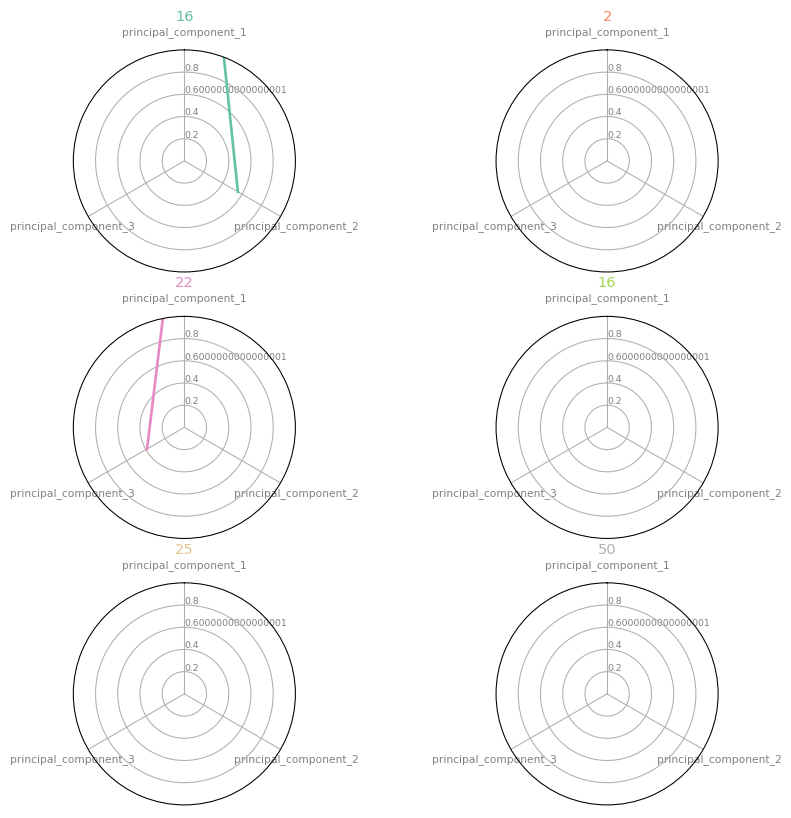

In [93]:
dfmaximin =  minimax(data_pca3, [2,3,4])
radarAllPlot(dfmaximin.head(6),[2,3,4])

In [101]:
dfSky = skylines(data, [2,3,4,5,6])

,id,date,time,lat,long,city,direction,depth,xm,md,richter,ms,mb
13,2.000000e+13,0.761194,0.0,0.839161,0.266199,22,1.000000,0.089109,0.027027,0.500000,0.0,0.0,0.0
33,2.000000e+13,0.716418,0.0,0.844406,0.570734,57,0.428571,0.306931,0.000000,0.486111,0.0,0.0,0.0
37,2.010000e+13,0.477612,0.0,0.300699,0.981102,5,0.428571,0.089109,0.162162,0.569444,0.0,0.0,0.0
43,1.970000e+13,0.313433,0.0,0.398601,0.072354,60,0.000000,0.049505,0.081081,0.527778,0.0,0.0,0.0
59,1.990000e+13,0.328358,0.0,0.534965,0.060475,60,1.000000,0.049505,0.000000,0.486111,0.0,0.0,0.0


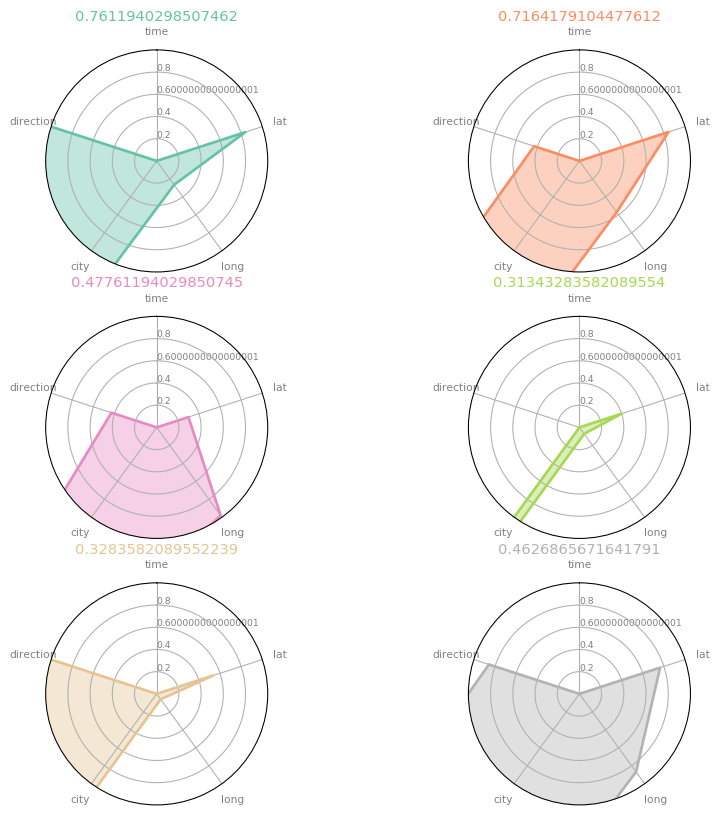

In [103]:
radarAllPlot(dfSky.head(6),[2,3,4,5,6])
dfSky.head()

In [16]:
data = pd.read_csv("earthquake.csv")
data = data.head(500)
data.head()
data = normalizarfechas(data,[1], 4, 0)
data = normalizarfechas(data,[2], 2, 2)
data = pd.DataFrame(data, columns = ['id', 'date', 'time', 'lat', 'long', 'city', 'direction', 'depth', 'xm', 'md', 'richter', 'ms', 'mb']) 
data = mapearColumnas(data, [1,2,5,6])
data.head()

,id,date,time,lat,long,city,direction,depth,xm,md,richter,ms,mb
0,2.000000e+13,46,1,39.04,40.38,2,8,10.0,4.1,4.1,0.0,0.0,0.0
1,2.010000e+13,29,1,40.79,30.09,45,8,5.2,4.0,3.8,4.0,0.0,0.0
2,1.980000e+13,37,1,38.58,27.61,34,7,0.0,3.7,0.0,0.0,0.0,3.7
3,2.000000e+13,34,1,39.47,36.44,29,7,10.0,3.5,3.5,0.0,0.0,0.0
4,2.000000e+13,62,1,40.80,30.24,15,7,7.0,4.3,4.3,0.0,0.0,0.0


In [17]:
indices = np.r_[1:6, 7:13]
data = normalizarDataset(data, indices)
data.head()

,id,date,time,lat,long,city,direction,depth,xm,md,richter,ms,mb
0,2.000000e+13,0.671642,0.0,0.520979,0.773218,0.016949,8,0.099010,0.162162,0.569444,0.000000,0.0,0.000000
1,2.010000e+13,0.417910,0.0,0.826923,0.217603,0.745763,8,0.051485,0.135135,0.527778,0.606061,0.0,0.000000
2,1.980000e+13,0.537313,0.0,0.440559,0.083693,0.559322,7,0.000000,0.054054,0.000000,0.000000,0.0,0.569231
3,2.000000e+13,0.492537,0.0,0.596154,0.560475,0.474576,7,0.099010,0.000000,0.486111,0.000000,0.0,0.000000
4,2.000000e+13,0.910448,0.0,0.828671,0.225702,0.237288,7,0.069307,0.216216,0.597222,0.000000,0.0,0.000000


In [19]:
dfMaM = maximin(data, indices)
dfMaM.head()

,id,date,time,lat,long,city,direction,depth,xm,md,richter,ms,mb,minVal
0,2.000000e+13,0.671642,0.0,0.520979,0.773218,0.016949,8,0.099010,0.162162,0.569444,0.000000,0.0,0.0,0.0
329,2.000000e+13,0.194030,0.0,0.534965,0.045356,0.254237,7,0.188119,0.000000,0.486111,0.000000,0.0,0.0,0.0
342,2.010000e+13,0.179104,0.0,0.444056,0.926026,0.169492,7,0.079208,0.297297,0.000000,0.666667,0.0,0.0,0.0
341,2.010000e+13,0.805970,0.0,0.445804,0.969762,0.169492,7,0.049505,0.027027,0.000000,0.545455,0.0,0.0,0.0
340,2.010000e+13,0.074627,0.0,0.496503,0.947084,0.169492,7,0.049505,0.108108,0.000000,0.590909,0.0,0.0,0.0


In [21]:
pesos = [0, 0, 10, 10, 10, 0, 30, 10, 10, 10, 10]

In [22]:
dfWA = weightedAverage(data, pesos, indices)
dfWA.head()

,id,date,time,lat,long,city,direction,depth,xm,md,richter,ms,mb,wa
464,1.920000e+13,0.373134,0.0,0.736014,0.581533,0.881356,7,0.099010,0.972973,0.916667,1.000000,1.000000,1.000000,0.903449
467,1.960000e+13,0.895522,0.0,0.816434,0.264039,0.830508,7,0.495050,0.621622,0.777778,0.848485,0.816901,0.861538,0.708055
465,1.950000e+13,0.656716,0.0,0.564685,0.818035,0.288136,7,0.594059,0.648649,0.791667,0.848485,0.830986,0.861538,0.694948
111,1.960000e+13,0.477612,0.0,0.277972,0.064795,0.067797,5,0.396040,0.891892,0.888889,0.954545,0.957746,0.969231,0.685665
276,1.940000e+13,0.582090,0.0,0.844406,0.400108,0.915254,1,0.099010,0.513514,0.708333,0.772727,0.732394,0.784615,0.669838


In [23]:
dfMiM = minimax(data, indices)
dfMiM.head()

,id,date,time,lat,long,city,direction,depth,xm,md,richter,ms,mb,maxVal
0,2.000000e+13,0.671642,0.0,0.520979,0.773218,0.016949,8,0.099010,0.162162,0.569444,0.000000,0.0,0.000000,0.0
341,2.010000e+13,0.805970,0.0,0.445804,0.969762,0.169492,7,0.049505,0.027027,0.000000,0.545455,0.0,0.000000,0.0
340,2.010000e+13,0.074627,0.0,0.496503,0.947084,0.169492,7,0.049505,0.108108,0.000000,0.590909,0.0,0.000000,0.0
339,2.010000e+13,0.074627,0.0,0.627622,0.681965,0.033898,7,0.049505,0.243243,0.000000,0.666667,0.0,0.661538,0.0
338,2.010000e+13,0.447761,0.0,0.531469,0.160367,0.440678,7,0.041584,0.054054,0.000000,0.560606,0.0,0.000000,0.0


In [24]:
lexMx = leximax(data, indices)
lexMx.head()

,id,date,time,lat,long,city,direction,depth,xm,md,...,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10
464,1.920000e+13,0.373134,0.0,0.736014,0.581533,0.881356,7,0.099010,0.972973,0.916667,...,1.000000,1.000000,0.972973,0.916667,0.881356,0.736014,0.581533,0.373134,0.099010,0.0
167,2.000000e+13,0.194030,0.0,0.818182,0.278078,0.830508,1,0.247525,1.000000,1.000000,...,1.000000,0.830508,0.818182,0.278078,0.247525,0.194030,0.000000,0.000000,0.000000,0.0
179,1.990000e+13,1.000000,0.0,0.791958,0.913607,0.983051,6,0.099010,0.054054,0.000000,...,0.983051,0.913607,0.791958,0.569231,0.099010,0.054054,0.000000,0.000000,0.000000,0.0
345,1.970000e+13,0.955224,0.0,0.321678,0.142549,0.067797,5,1.000000,0.351351,0.638889,...,0.955224,0.692308,0.651515,0.638889,0.633803,0.351351,0.321678,0.142549,0.067797,0.0
427,2.010000e+13,0.940299,1.0,0.753497,0.610691,0.881356,1,0.049505,0.324324,0.000000,...,0.940299,0.881356,0.753497,0.712121,0.707692,0.610691,0.324324,0.049505,0.000000,0.0


In [25]:
lexMn = leximin(data, indices)
lexMn.head()

,id,date,time,lat,long,city,direction,depth,xm,md,...,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10
490,1.940000e+13,0.985075,0.0,0.687063,0.652268,0.474576,5,0.495050,0.567568,0.750000,...,0.474576,0.495050,0.567568,0.652268,0.687063,0.750000,0.774648,0.803030,0.830769,0.985075
492,1.960000e+13,0.895522,0.0,0.819930,0.429806,0.915254,5,0.396040,0.486486,0.694444,...,0.396040,0.429806,0.486486,0.694444,0.718310,0.757576,0.784615,0.819930,0.895522,0.915254
137,1.970000e+13,0.955224,0.0,0.842657,0.412527,0.915254,4,0.326733,0.324324,0.625000,...,0.324324,0.326733,0.412527,0.619718,0.625000,0.681818,0.707692,0.842657,0.915254,0.955224
300,1.940000e+13,0.298507,0.0,0.825175,0.424946,0.915254,8,0.396040,0.459459,0.680556,...,0.298507,0.396040,0.424946,0.459459,0.680556,0.690141,0.742424,0.753846,0.825175,0.915254
188,1.940000e+13,0.298507,0.0,0.382867,0.835853,0.796610,8,0.990099,0.378378,0.666667,...,0.298507,0.378378,0.382867,0.666667,0.676056,0.727273,0.753846,0.796610,0.835853,0.990099


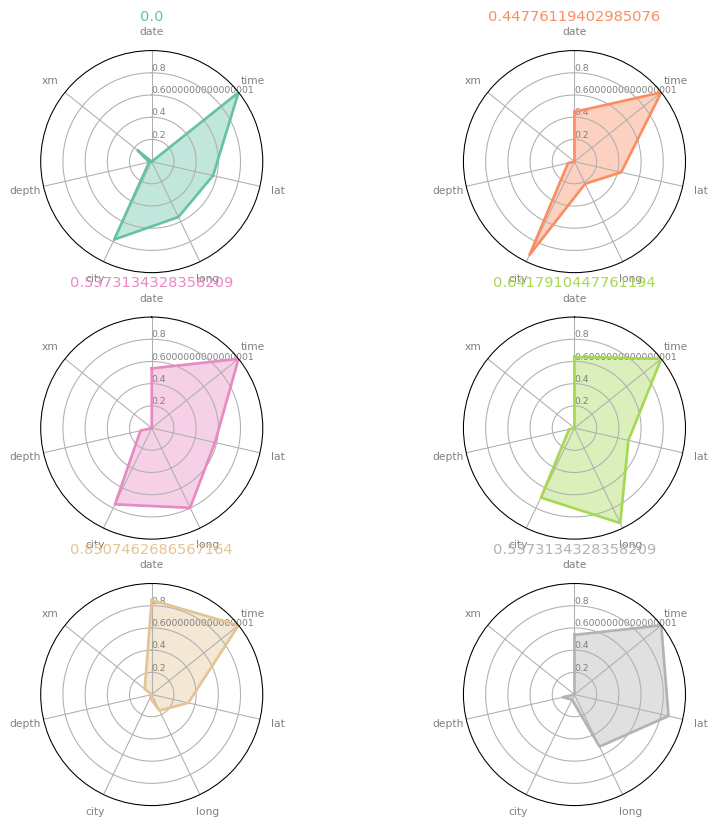

In [36]:
data = pd.read_csv("earthquake.csv")
data = data.head(500)
data.head()
data = normalizarfechas(data,[1], 4, 0)
data = normalizarfechas(data,[2], 2, 2)
data = pd.DataFrame(data, columns = ['id', 'date', 'time', 'lat', 'long', 'city', 'direction', 'depth', 'xm', 'md', 'richter', 'ms', 'mb']) 
data = mapearColumnas(data, [1,2,5,6])
indices = np.r_[1:6, 7:9]
data = normalizarDataset(data, indices)
dfmaximin =  minimax(data, indices)
dfmaximin.head(6)
radarAllPlot(dfmaximin.head(6),indices)

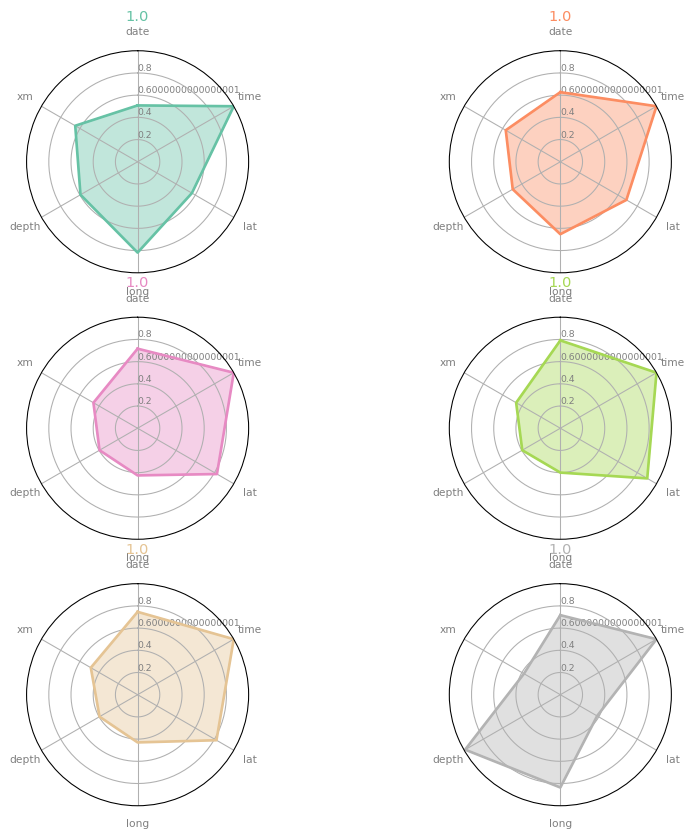

In [46]:
data = pd.read_csv("earthquake.csv")
data = data.head(500)
data.head()
data = normalizarfechas(data,[1], 4, 0)
data = normalizarfechas(data,[2], 2, 2)
data = pd.DataFrame(data, columns = ['date', 'time', 'lat', 'long', 'city', 'direction', 'depth', 'xm', 'md', 'richter', 'ms', 'mb']) 
data = mapearColumnas(data, [0,1,5])
indices = np.r_[0:4, 6:8]
data = normalizarDataset(data, indices)
maximin_ = maximin(data, indices)
maximin_.head()
radarAllPlot(maximin_.head(6),indices)

In [49]:
datapc2, x = pca(data, indices, 4)
datapc2.head()

,city,direction,md,richter,ms,mb,principal_component_1,principal_component_2,principal_component_3,principal_component_4
0,bingol,8,4.1,0.0,0.0,0.0,-0.034804,-0.558650,0.603891,0.547593
1,kocaeli,8,3.8,4.0,0.0,0.0,-0.422221,0.762671,-1.196344,-0.024047
2,manisa,4,0.0,0.0,0.0,3.7,-1.469307,-0.657865,-0.937170,0.430539
3,sivas,4,3.5,0.0,0.0,0.0,-0.365712,0.871401,0.924711,-0.597259
4,sakarya,4,4.3,0.0,0.0,0.0,0.420718,1.774975,-0.475975,-0.876075


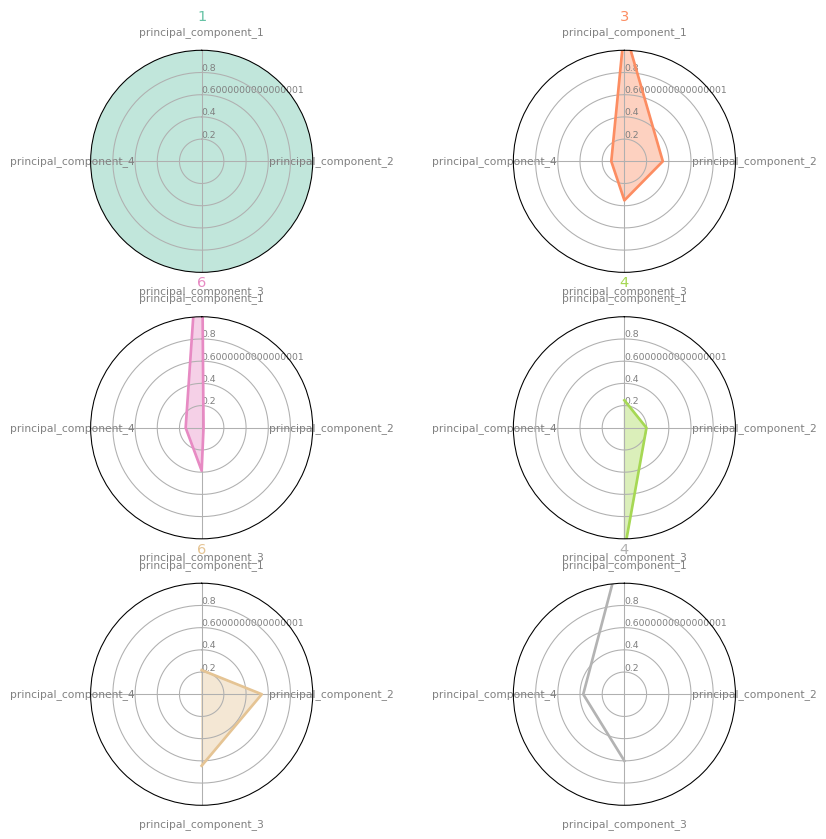

In [50]:
datapc2, x = pca(data, indices, 4)
datapc2.head()
maximin_ = maximin(datapc2, [6,7,8,9])
maximin_.head()
radarAllPlot(maximin_.head(6),[6,7,8,9])

In [61]:
data = pd.read_csv("earthquake.csv")
data = data.head(500)
data.head()

,id,date,time,lat,long,country,city,area,direction,dist,depth,xm,md,richter,mw,ms,mb
0,2.000000e+13,2003.05.20,12:17:44 AM,39.04,40.38,turkey,bingol,baliklicay,west,0.1,10.0,4.1,4.1,0.0,NaN,0.0,0.0
1,2.010000e+13,2007.08.01,12:03:08 AM,40.79,30.09,turkey,kocaeli,bayraktar_izmit,west,0.1,5.2,4.0,3.8,4.0,NaN,0.0,0.0
2,1.980000e+13,1978.05.07,12:41:37 AM,38.58,27.61,turkey,manisa,hamzabeyli,south_west,0.1,0.0,3.7,0.0,0.0,NaN,0.0,3.7
3,2.000000e+13,1997.03.22,12:31:45 AM,39.47,36.44,turkey,sivas,kahvepinar_sarkisla,south_west,0.1,10.0,3.5,3.5,0.0,NaN,0.0,0.0
4,2.000000e+13,2000.04.02,12:57:38 AM,40.80,30.24,turkey,sakarya,meseli_serdivan,south_west,0.1,7.0,4.3,4.3,0.0,NaN,0.0,0.0


In [62]:
data = pd.read_csv("earthquake.csv")
data = data.head(500)
data = normalizarfechas(data,[1], 5, 3, 0)
data = normalizarfechas(data,[2], 2, 2, -1)
data = pd.DataFrame(data, columns = ['date', 'time', 'lat', 'long', 'city', 'direction', 'depth', 'xm', 'md', 'richter', 'ms', 'mb']) 
data = mapearColumnas(data, [0,1,4,5])
indices = np.r_[0:5, 6:9]
data = normalizarDataset(data, indices)
dflx =  leximax(data, indices)
dflx.head(6)
radarAllPlot(dflx.head(6),indices)

,date,time,lat,long,city,direction,depth,xm,md,richter,ms,mb
0,05,12AM,39.04,40.38,bingol,west,10.0,4.1,4.1,0.0,0.0,0.0
1,08,12AM,40.79,30.09,kocaeli,west,5.2,4.0,3.8,4.0,0.0,0.0
2,05,12AM,38.58,27.61,manisa,south_west,0.0,3.7,0.0,0.0,0.0,3.7
3,03,12AM,39.47,36.44,sivas,south_west,10.0,3.5,3.5,0.0,0.0,0.0
4,04,12AM,40.80,30.24,sakarya,south_west,7.0,4.3,4.3,0.0,0.0,0.0


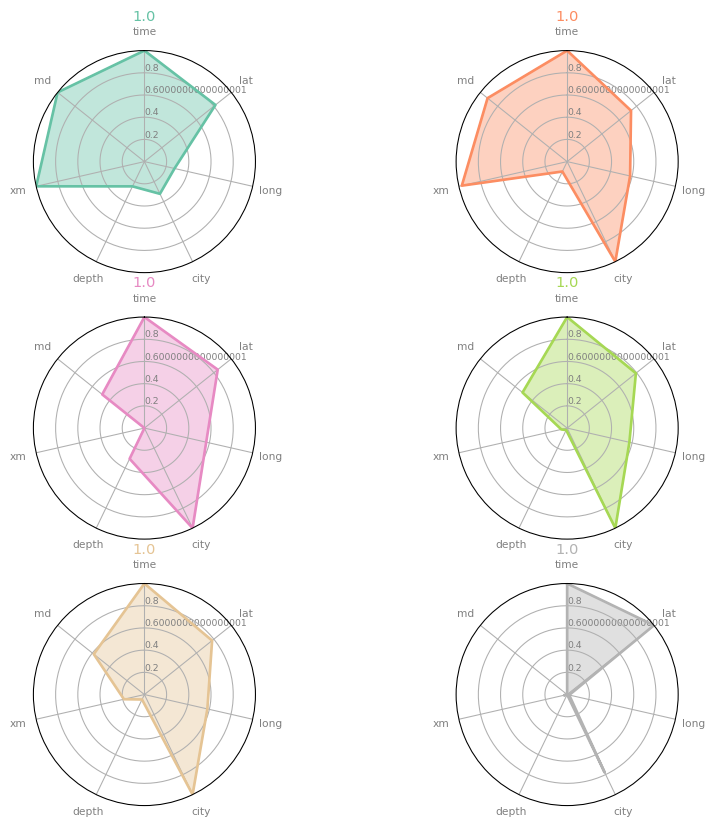

In [64]:
data = mapearColumnas(data, [0,1,4,5])
indices = np.r_[1:5, 6:9]
data = normalizarDataset(data, indices)
dflx =  leximax(data, indices)
dflx.head(6)
radarAllPlot(dflx.head(6),indices)

## Predecir la direccion de terremotos en turquia con knn

In [78]:
data = pd.read_csv("earthquake.csv")
data = data.head(500)
data = normalizarfechas(data,[1], 5, 3, 0)
data = normalizarfechas(data,[2], 2, 2, -1)
data = pd.DataFrame(data, columns = ['date', 'time', 'lat', 'long', 'city', 'direction', 'depth', 'xm', 'md', 'richter', 'ms', 'mb']) 
data = mapearColumnas(data, [0,1,4,5])
indices = np.r_[0:5, 6:9]
data = normalizarDataset(data, indices)
data.head()
a,b,c = knn(data, indices, 4,5)

In [81]:
print(c) 

[168, 21, 101, 93, 21, 66, 15, 15]


In [83]:
a.head()

,date,time,lat,long,city,direction,depth,xm,md,richter,ms,mb,predicted class
0,0.363636,1.0,0.520979,0.773218,0.762712,8,0.099010,0.162162,0.569444,0.0,0.0,0.0,1
1,0.909091,1.0,0.826923,0.217603,0.169492,8,0.051485,0.135135,0.527778,4.0,0.0,0.0,2
2,0.363636,1.0,0.440559,0.083693,0.728814,4,0.000000,0.054054,0.000000,0.0,0.0,3.7,4
3,0.000000,1.0,0.596154,0.560475,0.779661,4,0.099010,0.000000,0.486111,0.0,0.0,0.0,3
4,0.727273,1.0,0.828671,0.225702,0.254237,4,0.069307,0.216216,0.597222,0.0,0.0,0.0,4


## Grafico de Predicciones de direcciones mapeadas

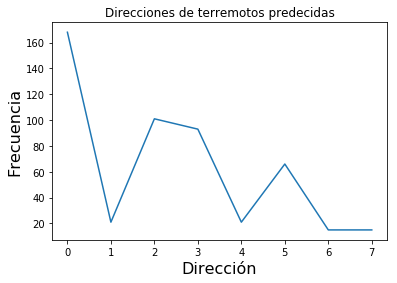

In [84]:
import matplotlib.pyplot as plt

x = [i for i in range(len(c))]
y = c
    
plt.plot(x,y)

plt.title('Direcciones de terremotos predecidas')
plt.ylabel('Frecuencia', fontsize=16)
plt.xlabel('Dirección', fontsize=16)

plt.show()